# Lecture 12: Resampling Methods

Let's review what we have learned:

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
X = mnist.data
y = mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
sgd_clf.fit(X_train, y_train_5)

In [ ]:
!git clone https://github.com/amueller/introduction_to_ml_with_python
%cd /content/introduction_to_ml_with_python
from preamble import *

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X, y = mglearn.datasets.make_wave(n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LinearRegression().fit(X_train, y_train)

Why do we need a test data?

    -   For the first example, the test data is given
    -   For the second example, we split the given data into two

But the more important question is: how do we decide which one to use?

Consider the linear model:
$$y = \beta_0 + \beta_1 x_1 + \epsilon$$
$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon$$
$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1^2+\epsilon$$

Classification problems: 

-   SGD classifier vs KNN classifier
    -   If KNN looks better, how many neighbors?

Resampling method (or Cross validation) allows us to compare the different models

Largely, given the data we

- Estimate the parameters according to the models
- Evaluate how well the models would work

For example, in order to estimate the variability of a linear
regression fit, 

    - we can repeatedly draw different samples from the training data
    - fit a linear regression to each new sample, and then examine the extent to which the resulting fits differ

Given a data set, the use of a particular statistical learning method is warranted
if it results in a low test error

However, in most cases, *a test set is not available*.

In the absence of a test set, a number of techniques can be used to estimate this quantity using the available training data

Given that we do not have a test set, we ESTIMATE the test error associated with fitting a particular learning method on a set of observations

## 1. Validation Set Appraoch

 It involves randomly dividing the available set of observations into two parts, *a training set* and *a validation set* (or hold-out set).

    1. the model is fit on the training set
    2. the fitted model is used to predict the responses for the observations in the validation set
    3. the resulting validation set error provides an estimate of the test error rate

Let's recall auto data in the previous homework.

- We want to build a model that predicts mpg using horsepower

In [4]:
import pandas as pd

df = pd.read_csv('https://www.statlearning.com/s/Auto.csv', na_values= "?")

In [10]:
df = df.dropna().reset_index(drop = True) # reset index

In [17]:
df.shape

(392, 9)

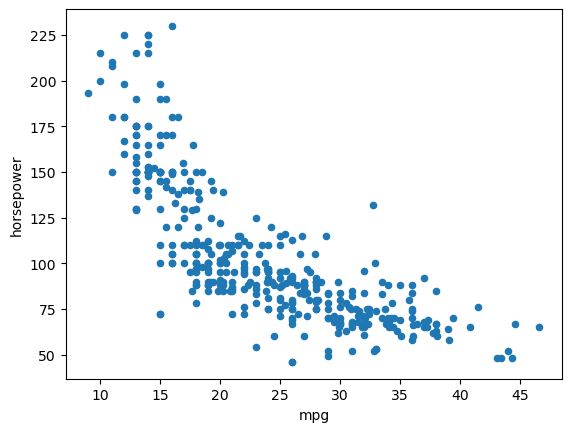

In [15]:
import matplotlib.pyplot as plt
df.plot.scatter('mpg','horsepower')
plt.show()

It is natural to wonder whether adding polynomials might provide even better results

    - We answer this question by looking at the p-values associated with a cubic term and higher-order polynomial terms in a linear regression

We could also answer this question using the validation method

1. Randomly split the 392 observations into two sets
    -   training: 196 / validation set: 196
    -   The validation set error rates that result from fitting various regression models on the training sample and evaluating their performance on the validation sample

In [23]:
from sklearn.preprocessing import PolynomialFeatures

In [30]:
poly = PolynomialFeatures(degree=10, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(df[['horsepower']])
X_poly = pd.DataFrame(X_poly)

In [34]:
X_poly.shape

(392, 10)

In [105]:
df = pd.concat([df['mpg'],X_poly],axis=1)

In [106]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [107]:
train_set, hold_set = shuffle_and_split_data(df, 0.5)
print(len(train_set),len(hold_set))

196 196


In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()

In [109]:
X_train_ = train_set.iloc[:,1:]
X_test_ = hold_set.iloc[:,1:]
mse = []
for i in range(10):
    lr.fit(X_train_.iloc[:,:i+1],train_set.iloc[:,0])
    y_pred = lr.predict(X_test_.iloc[:,:i+1])
    mse.append(mean_squared_error(y_pred, hold_set.iloc[:,0]))
mse = pd.DataFrame(mse)
mse = mse.reset_index()
mse[['index']] += 1


# FIX the FIGURE details (2 figures here)

<AxesSubplot:xlabel='index'>

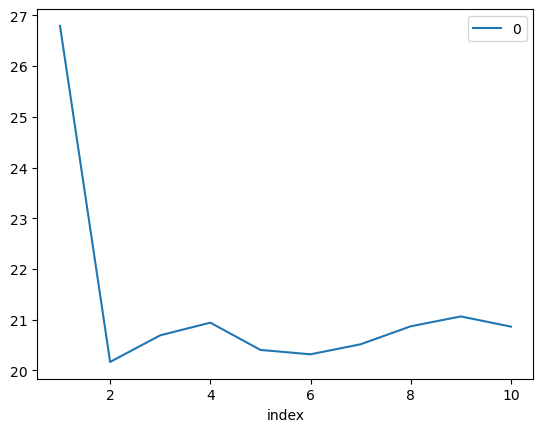

In [110]:
mse.plot(x = 'index', y = 0)

The validation set MSE for the quadratic fit is considerably smaller than for the linear fit. 

Not sure a higher polynomial terms

_Q_. What's the idea behind the train-validation split? And, what's the problem of this approach?

If we *repeat* the process of randomly splitting the sample set into two parts, we will get a somewhat different estimate for the test MSE

In [111]:
mse

,index,0
0,1,26.790410
1,2,20.168132
2,3,20.692480
3,4,20.941926
4,5,20.404692
5,6,20.318240
6,7,20.515724
7,8,20.870312
8,9,21.064655
9,10,20.863672


In [112]:
for i in range(9):
    train_set, hold_set = shuffle_and_split_data(df, 0.5)
    X_train_ = train_set.iloc[:,1:]
    X_test_ = hold_set.iloc[:,1:]
    mse_ = []
    for j in range(10):
        lr.fit(X_train_.iloc[:,:j+1],train_set.iloc[:,0])
        y_pred = lr.predict(X_test_.iloc[:,:j+1])
        mse_.append(mean_squared_error(y_pred, hold_set.iloc[:,0]))
    mse_ = pd.DataFrame(mse_)
    mse = pd.concat([mse,mse_],axis= 1)

In [113]:
mse.columns = ['num_poly','1','2','3','4','5','6','7','8','9','10']

In [114]:
mse

,num_poly,1,2,3,4,5,6,7,8,9,10
0,1,26.790410,26.214311,21.281729,22.150409,22.911706,25.521888,25.610460,25.223843,21.097135,25.983723
1,2,20.168132,22.421330,16.672435,17.246115,16.553382,19.921928,22.595203,20.761688,17.066609,22.227364
2,3,20.692480,23.001009,16.663182,17.197120,16.500446,20.038848,23.410751,20.844037,17.517361,22.398676
3,4,20.941926,22.934069,16.951150,17.266769,16.417210,19.937405,23.693753,20.775170,17.453385,22.323983
4,5,20.404692,22.435706,17.150567,16.711444,16.300475,19.505663,22.910765,20.241184,16.985574,21.979253
5,6,20.318240,22.213693,16.926757,16.545252,16.080900,19.227350,22.659073,19.956708,17.053629,22.010571
6,7,20.515724,22.389625,17.086633,16.803492,16.178533,19.541293,22.898876,20.193742,17.187194,21.967584
7,8,20.870312,22.636342,17.087264,16.992521,16.194321,19.747486,23.106882,20.460722,17.244903,22.089952
8,9,21.064655,22.565043,16.896587,16.890977,16.310689,19.755601,23.053589,20.510607,17.233486,22.185774
9,10,20.863672,23.277593,16.643013,16.506830,16.457158,19.529789,22.717496,20.347662,17.328767,22.079288


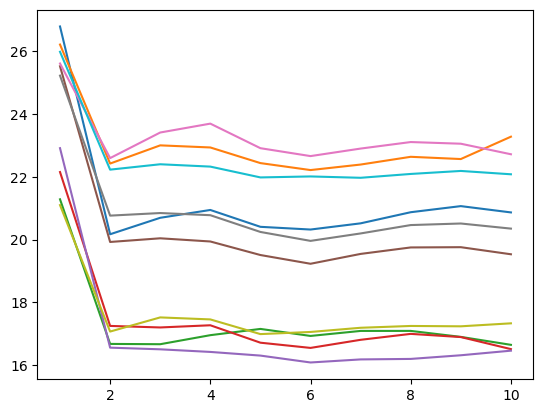

In [118]:
for i in range(10):
    plt.plot(mse.num_poly,mse[[str(i+1)]])    
plt.show()

1. As an illustration, the Figure displays ten different validation set MSE curves from the Auto data set, produced using ten different random splits of the observations into training and validation sets. 

2. All ten curves indicate that the model with a quadratic term has a dramatically smaller validation set MSE than the model with only a linear term. 

3. Furthermore, all ten curves indicate that there is not much benefit in including cubic or higher-order polynomial terms in the model.

4. Hard to find which model results in the smallest validation set MSE

5. Potential Conclusion: the linear fit is not adequate for this data

### Takeaway: validation set approach

1. the validation estimate of the test error rate can be highly variable, depending on precisely which observations are included in the training set and which observations are included in the validation set

2. In the validation approach, only a subset of the observations—those that are included in the training set rather than in the validation set—are used to fit the model
    - Since statistical methods tend to perform worse when trained on fewer observations, this suggests that the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set

## 2. Leave-One-Out Cross-Validation (LOOCV)

LOOCV is a refinement of the validation set approach

- Like the validation set approach, LOOCV involves splitting the set of observations into two parts.
- A single observation $(x_1, y_1)$ is used for the validation set, and the remaining observations $\{(x_2, y_2),...,(x_n, y_n)\}$ make up the training set
    - Since $(x_1, y_1)$ was not used in the fitting process, $MSE_1 = (y_1 − \hat{y}_1)^2$ provides an approximately unbiased estimate for the test error
- Repeat the procedure by selecting $(x_2,y_2)$ for the validation, training the model on the $n-1$ remaining obs, and computing $MSE_2 = (y_2 − \hat{y}_2)^2$ 
- Repeating this appraoch $n$ times produces $n$ squared errors
- LOOCV estimate for the test MSE is the average of these $n$ test error estimates:
$$CV_{(n)}=\frac{1}{n} \sum_{i=1}^{n}MSE_{i}$$

In [119]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [120]:
cv = LeaveOneOut()

In [121]:
df

,mpg,0,1,2,3,4,5,6,7,8,9
0,18.0,130.0,16900.0,2197000.0,285610000.0,3.712930e+10,4.826809e+12,6.274852e+14,8.157307e+16,1.060450e+19,1.378585e+21
1,15.0,165.0,27225.0,4492125.0,741200625.0,1.222981e+11,2.017919e+13,3.329566e+15,5.493784e+17,9.064743e+19,1.495683e+22
2,18.0,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
3,16.0,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
4,17.0,140.0,19600.0,2744000.0,384160000.0,5.378240e+10,7.529536e+12,1.054135e+15,1.475789e+17,2.066105e+19,2.892547e+21
...,...,...,...,...,...,...,...,...,...,...,...
387,27.0,86.0,7396.0,636056.0,54700816.0,4.704270e+09,4.045672e+11,3.479278e+13,2.992179e+15,2.573274e+17,2.213016e+19
388,44.0,52.0,2704.0,140608.0,7311616.0,3.802040e+08,1.977061e+10,1.028072e+12,5.345973e+13,2.779906e+15,1.445551e+17
389,32.0,84.0,7056.0,592704.0,49787136.0,4.182119e+09,3.512980e+11,2.950903e+13,2.478759e+15,2.082157e+17,1.749012e+19
390,28.0,79.0,6241.0,493039.0,38950081.0,3.077056e+09,2.430875e+11,1.920391e+13,1.517109e+15,1.198516e+17,9.468276e+18


In [122]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [132]:
mse = []
for i in range(10):
    scores = cross_val_score(lr, X = X.iloc[:,:i+1],y = y, scoring='neg_mean_squared_error', cv = cv, n_jobs= -1)
    mse.append(np.mean(np.absolute(scores)))

In [134]:
mse = pd.DataFrame(mse)
mse = mse.reset_index()
mse[['index']] += 1

<AxesSubplot:xlabel='index'>

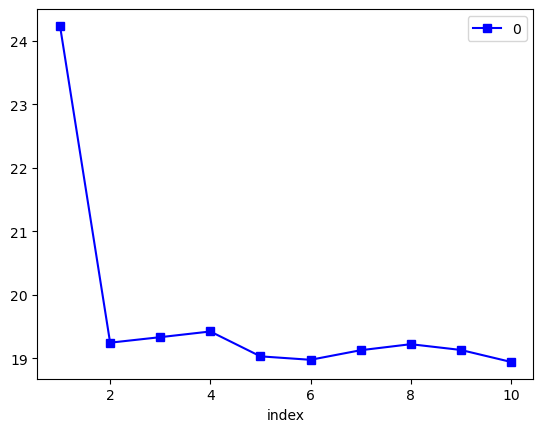

In [137]:
mse.plot(x = 'index', y = 0, style='bs-')

LOOCV has a couple of major advantages over the validation set approach

1. it has far less bias
    - In LOOCV, we repeatedly fit the statistical learning method using training sets that contain $n−1$ observations, almost as many as are in the entire data set
    - Consequently, the LOOCV approach tends not to overestimate the test error rate as much as the validation set approach does
2. there is no randomness in the training/validation set splits

Downside?

- LOOCV has the potential to be expensive to implement, since the model has to be fit $n$ times.
- This can be very time consuming if $n$ is large, and if each individual model is slow to fit


## 3. k-Fold Cross-Validation

An alternative to LOOCV is k-fold CV. 

- This approach involves randomly k-fold CV dividing the set of observations into k groups, or folds, of approximately equal size.
    -  The first fold is treated as a validation set, and the method is fit on the remaining $k−1$ folds
    -  The mean squared error, $MSE_1$, is then computed on the observations in the held-out fold
    - This procedure is repeated $k$ times; each time, a different group of observations is treated as a validation set
        - This process results in $k$ estimates of the test error, $MSE_1, MSE_2,..., MSE_k$..
        - The k-fold CV estimate is computed by averaging these values:
        $$\text{CV}_{(k)}=\frac{1}{k}\sum_{i=1}^{k}MSE_i$$

LOOCV is a special case of k-fold CV in which $k$ is set to equal $n$

 In practice, one typically performs $k$-fold CV using $k = \{3,5,10\}$. 

### Q. What is the advantage of using $k = 5$ or $k = 10$ rather than $k = n$? 

The most obvious advantage is computational. LOOCV requires fitting the statistical learning method n times. 

- The cross-validation is a very general approach that can be applied to almost any statistical learning
method
    - performing LOOCV may pose computational problems for heavy models, especially if $n$ is large
- In contrast, performing 10-fold CV requires fitting the learning procedure only ten times, which may be much more feasible

In [159]:
from sklearn.model_selection import KFold

In [203]:
kfold = KFold(n_splits = 10, shuffle = True)

In [204]:
mse = pd.DataFrame()
for train, hold in kfold.split(df):
    X_train_ = df.iloc[train,1:]
    X_hold_ =  df.iloc[hold,1:]
    y_train_ = df.iloc[train,0]
    y_hold_ = df.iloc[hold,0]
    
    mse_ = []
    for j in range(10):
        lr.fit(X_train_.iloc[:,:j+1],y_train_)
        y_pred = lr.predict(X_hold_.iloc[:,:j+1])
        mse_.append(np.mean(mean_squared_error(y_pred, y_hold_)))
    mse_ = pd.DataFrame(mse_)
    mse = pd.concat([mse,mse_],axis= 1)

<AxesSubplot:xlabel='index'>

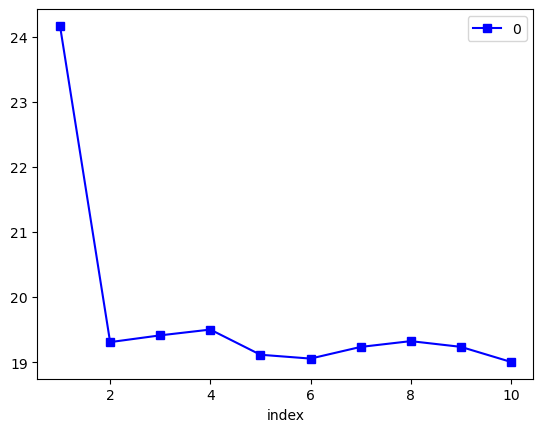

In [207]:
mse = pd.DataFrame(mse.mean(axis = 1))
mse = mse.reset_index()
mse[['index']] += 1
mse.plot(x = 'index', y = 0, style='bs-')

In [209]:
for i in range(9):
    kfold = KFold(n_splits = 10, shuffle = True)
    mse2 = pd.DataFrame()
    for train, hold in kfold.split(df):
        X_train_ = df.iloc[train,1:]
        X_hold_ =  df.iloc[hold,1:]
        y_train_ = df.iloc[train,0]
        y_hold_ = df.iloc[hold,0]
    
        mse_ = []
        for j in range(10):
            lr.fit(X_train_.iloc[:,:j+1],y_train_)
            y_pred = lr.predict(X_hold_.iloc[:,:j+1])
            mse_.append(np.mean(mean_squared_error(y_pred, y_hold_)))
        mse_ = pd.DataFrame(mse_)
        mse2 = pd.concat([mse2,mse_],axis= 1)
    mse2 = pd.DataFrame(mse2.mean(axis = 1))
    mse = pd.concat([mse,mse2],axis= 1)

In [211]:
mse.columns = ['num_poly','1','2','3','4','5','6','7','8','9','10']

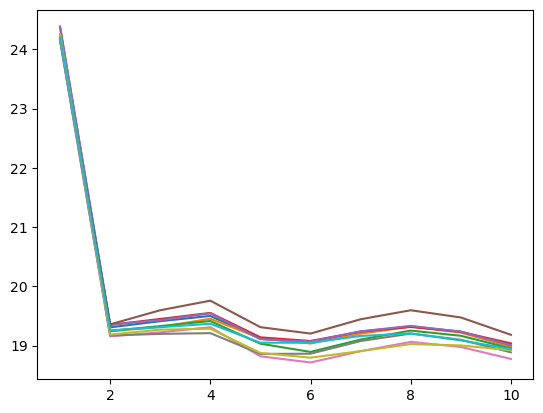

In [212]:
for i in range(10):
    plt.plot(mse.num_poly,mse[[str(i+1)]])    
plt.show()

The Figure displays ten different 10-fold CV estimates for the Auto data set, each resulting from a different random split of the observations into ten folds

    -   there is some variability in the CV estimates as a result of the variability in how the observations are divided into ten folds
    -   But this variability is typically much lower than the variability in the test error estimates that results from the validation set approach

# 4. Dicussion

Note that $k$-fold CV with $k<n$ has a computational advantage to LOOCV

A less obvious but potentially more important advantage of k-fold CV is that it often gives more accurate estimates of the test error rate than does LOOCV

This has to do with a bias-variance trade-off. What is the trade-off?

 - The validation set approach can lead to overestimates of the test error rate, since in this approach the training set used to fit the statistical learning method contains only half the observations of the entire data set
 - It is not hard to see that LOOCV will give approximately unbiased estimates of the test error,
since each training set contains $n−1$ observations, which is almost as many as the number of observations in the full data set.
 - Performing k-fold CV for, say, $k = 5$ or $k = 10$ will lead to an intermediate level of bias, since each training set contains approximately $(k − 1)n/k$ observations


### Then, why do we need k-fold CV over LOOCV? 
 - See the clear advantage of LOOCV from the perspective of bias reduction
 - However, we must also consider the procedure's variance.
 - It turns out that LOOCV has higher variance than does k-fold CV with $k<n$.

### Why?

- When we perform LOOCV, we are in effect averaging the outputs of n fitted models, each of which is trained on an almost identical set of observations
    - therefore, these outputs are highly (positively) correlated with each other
- In contrast, when we perform k-fold CV with $k<n$, we are averaging the outputs of k fitted models that are somewhat less correlated with each other
    -  since the overlap between the training sets in each model is smaller

Since the mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated, the test error estimate resulting from LOOCV tends
to have higher variance than does the test error estimate resulting from k-fold CV

To summarize, there is a bias-variance trade-off associated with the choice of $k$ in k-fold cross-validation. 

Typically, given these considerations, one performs k-fold cross-validation using $k = 5$ or $k = 10$, as these values have been shown empirically to yield test error rate estimates that suffer
neither from excessively high bias nor from very high variance.

### Further discussion

Cross-validation can also be a very useful approach in the classification setting. 